# First we will run experiments on using six landmarks only. We will use the folds that were created. 
# We will edit these parameters to see what works best: 
- learning rate
- augmentations / no augmentations
- model space for LSTM cell 

In [6]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [2]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [3]:
from glob import glob
def cross_validate(model, callbacks):
    for i in range(X.shape[0]): 
        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = callbacks)

        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [4]:
import tensorflow as tf 

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_5 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_7 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_8 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_9 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_10 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_11 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

using patience of 5
using no aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 0.3839 - accuracy: 0.8625 - val_loss: 0.6641 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 124ms/step - loss: 0.3579 - accuracy: 0.8750 - val_loss: 0.6866 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 123ms/step - loss: 0.3601 - accuracy: 0.8500 - val_loss: 0.5989 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.3639 - accuracy: 0.8500 - val_loss: 0.6706 - val_accuracy: 0.7000
Epoch 5/50
3/3 [==============================] - 0s 124ms/step - loss: 0.4040 - accuracy: 0.8500 - val_loss: 0.7112 - val_accuracy: 0.7000
Epoch 6/50
3/3 [==============================] - 0s 125ms/step - loss: 0.3332 - accuracy: 0.8500 - val_loss: 0.6987 - val_accuracy: 0.7000
Epoch 7/50
3/3 [==============================] - 0s 121ms/step - loss: 0.3603 - accuracy: 0.8500 - val_loss: 0.61

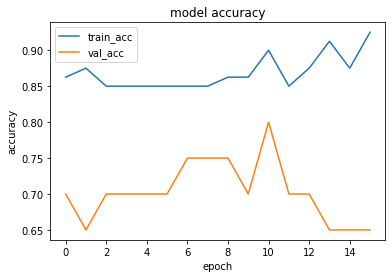

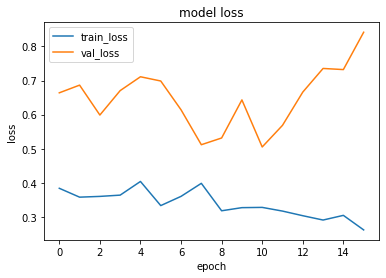

1it [00:00, 13315.25it/s]
file is another_control.mov, prediction is [[0.08868036]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.9841169]]
1it [00:00, 16448.25it/s]
file is control_far.mov, prediction is [[0.07741013]]
1it [00:00, 14027.77it/s]
file is long_armflapping.mov, prediction is [[0.3071158]]
1it [00:00, 15827.56it/s]
file is me_reading_control.mov, prediction is [[0.07406902]]
1it [00:00, 16131.94it/s]
file is me_armflapping.mov, prediction is [[0.94456625]]
Epoch 1/50
3/3 [==============================] - 0s 141ms/step - loss: 0.4531 - accuracy: 0.8375 - val_loss: 0.3071 - val_accuracy: 0.9000
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.3986 - accuracy: 0.8625 - val_loss: 0.2836 - val_accuracy: 0.9000
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.4832 - accuracy: 0.8125 - val_loss: 0.3885 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.521

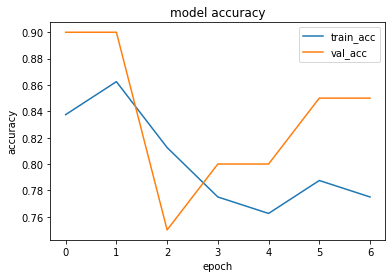

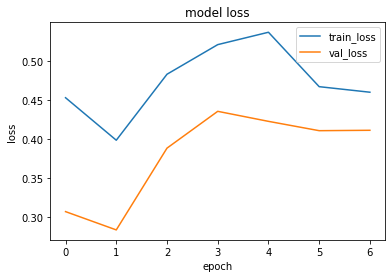

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.37254208]]
1it [00:00, 16912.52it/s]
file is short_armflapping.mov, prediction is [[0.64671487]]
1it [00:00, 15887.52it/s]
file is control_far.mov, prediction is [[0.35986856]]
1it [00:00, 15420.24it/s]
file is long_armflapping.mov, prediction is [[0.48196936]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.36168087]]
1it [00:00, 17476.27it/s]
file is me_armflapping.mov, prediction is [[0.5705012]]
Epoch 1/50
3/3 [==============================] - 0s 154ms/step - loss: 0.4432 - accuracy: 0.8125 - val_loss: 0.3992 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.4123 - accuracy: 0.8375 - val_loss: 0.3758 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.4190 - accuracy: 0.8000 - val_loss: 0.3757 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 131ms/step - loss: 0.37

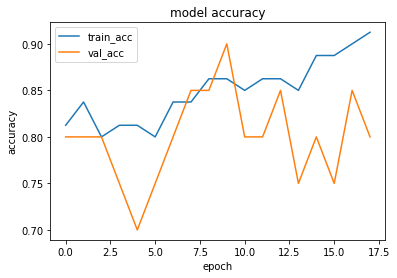

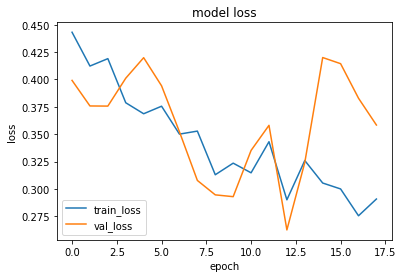

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.21101302]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.9962913]]
1it [00:00, 11491.24it/s]
file is control_far.mov, prediction is [[0.22343811]]
1it [00:00, 13148.29it/s]
file is long_armflapping.mov, prediction is [[0.26969388]]
1it [00:00, 14315.03it/s]
file is me_reading_control.mov, prediction is [[0.22070754]]
1it [00:00, 12671.61it/s]
file is me_armflapping.mov, prediction is [[0.98099315]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.4089 - accuracy: 0.8500 - val_loss: 0.4863 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.4674 - accuracy: 0.8375 - val_loss: 0.5249 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.3941 - accuracy: 0.8750 - val_loss: 0.5030 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 135ms/step - loss: 0.38

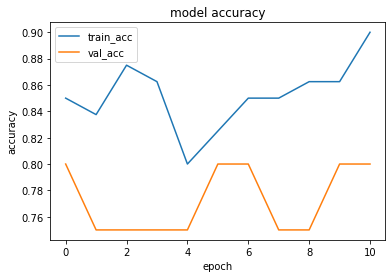

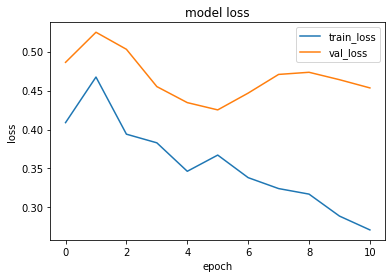

1it [00:00, 12633.45it/s]
file is another_control.mov, prediction is [[0.25840205]]
1it [00:00, 16131.94it/s]
file is short_armflapping.mov, prediction is [[0.9875145]]
1it [00:00, 15141.89it/s]
file is control_far.mov, prediction is [[0.28175497]]
1it [00:00, 16384.00it/s]
file is long_armflapping.mov, prediction is [[0.33795896]]
1it [00:00, 11008.67it/s]
file is me_reading_control.mov, prediction is [[0.28117633]]
1it [00:00, 16578.28it/s]
file is me_armflapping.mov, prediction is [[0.96338964]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.3356 - accuracy: 0.8375 - val_loss: 0.2527 - val_accuracy: 0.9000
Epoch 2/50
3/3 [==============================] - 0s 154ms/step - loss: 0.3337 - accuracy: 0.8500 - val_loss: 0.2519 - val_accuracy: 0.9000
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.3312 - accuracy: 0.8500 - val_loss: 0.2515 - val_accuracy: 0.9000
Epoch 4/50
3/3 [==============================] - 0s 148ms/step - loss: 0.25

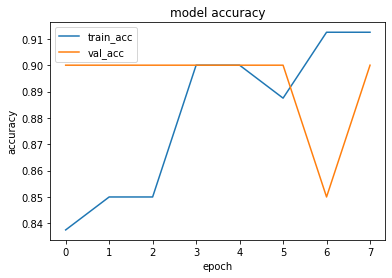

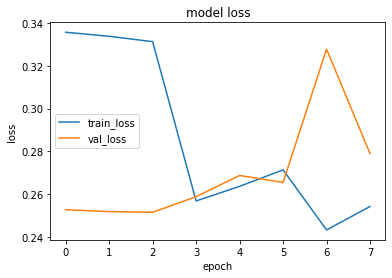

1it [00:00, 14463.12it/s]
file is another_control.mov, prediction is [[0.17488372]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.99712837]]
1it [00:00, 16320.25it/s]
file is control_far.mov, prediction is [[0.24576896]]
1it [00:00, 16131.94it/s]
file is long_armflapping.mov, prediction is [[0.2744708]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.20669031]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.9802751]]
using patience of 10
using aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.2616 - accuracy: 0.9125 - val_loss: 0.5275 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5044 - accuracy: 0.8125 - val_loss: 0.4682 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 138ms/step - loss: 0.3052 - accuracy: 0.9250 - val_loss: 0.4896 - val_accuracy: 0.7500
Epoch 4/50
3/3 [=================

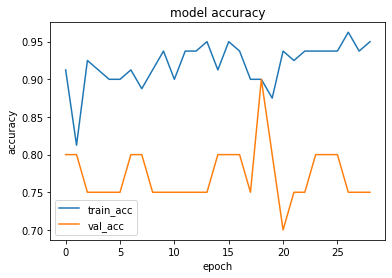

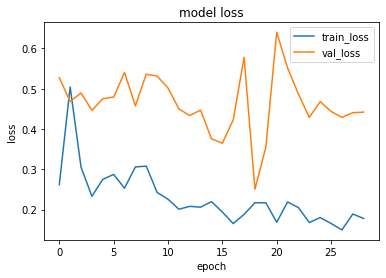

1it [00:00, 16070.13it/s]
file is another_control.mov, prediction is [[0.05221626]]
1it [00:00, 14315.03it/s]
file is short_armflapping.mov, prediction is [[0.9824177]]
1it [00:00, 13530.01it/s]
file is control_far.mov, prediction is [[0.07339251]]
1it [00:00, 14513.16it/s]
file is long_armflapping.mov, prediction is [[0.08682519]]
1it [00:00, 16912.52it/s]
file is me_reading_control.mov, prediction is [[0.05409634]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.9966173]]
Epoch 1/50
3/3 [==============================] - 0s 153ms/step - loss: 0.2252 - accuracy: 0.9125 - val_loss: 0.1354 - val_accuracy: 0.9500
Epoch 2/50
3/3 [==============================] - 0s 153ms/step - loss: 0.1554 - accuracy: 0.9250 - val_loss: 0.2289 - val_accuracy: 0.9000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.1288 - accuracy: 0.9500 - val_loss: 0.2174 - val_accuracy: 0.9000
Epoch 4/50
3/3 [==============================] - 0s 150ms/step - loss: 0.121

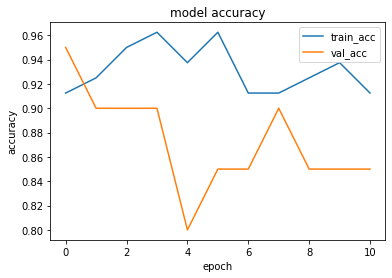

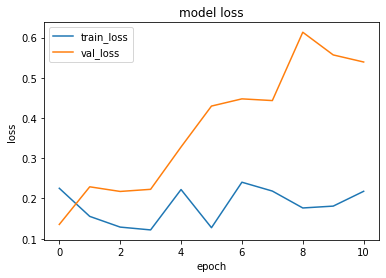

1it [00:00, 13530.01it/s]
file is another_control.mov, prediction is [[0.37905]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.9995859]]
1it [00:00, 16912.52it/s]
file is control_far.mov, prediction is [[0.31605718]]
1it [00:00, 14513.16it/s]
file is long_armflapping.mov, prediction is [[0.94740486]]
1it [00:00, 12826.62it/s]
file is me_reading_control.mov, prediction is [[0.37369367]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.99857986]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.3534 - accuracy: 0.8625 - val_loss: 0.1909 - val_accuracy: 0.9500
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.3086 - accuracy: 0.8750 - val_loss: 0.0695 - val_accuracy: 1.0000
Epoch 3/50
3/3 [==============================] - 0s 137ms/step - loss: 0.2542 - accuracy: 0.8875 - val_loss: 0.2244 - val_accuracy: 0.9500
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.1943 

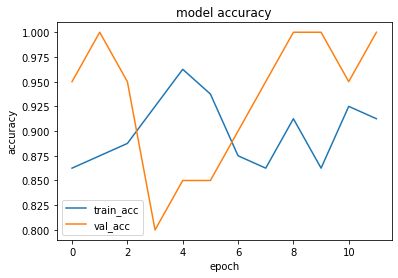

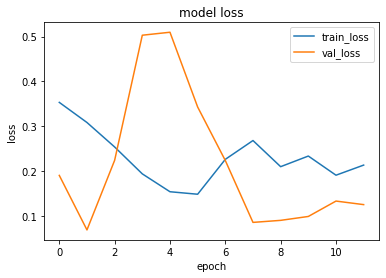

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.15764025]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.9992567]]


KeyboardInterrupt: 

In [12]:
from copy import deepcopy
from tqdm import tqdm 
for i, model in enumerate([model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11]): 
    aug_model = deepcopy(model)
    aug_model.layers.insert(0, Augmenter()) # insert augmentation layer 

    early_stopping_10 = tf.keras.callbacks.EarlyStopping(patience=10)
    early_stopping_5 = tf.keras.callbacks.EarlyStopping(patience=5)

    patience = [5, 10]
    
    for i, test_model in enumerate([model, aug_model]):
        for learning_rate in [0.01, 0.001, 0.0005, 0.0001]: 
            for i, early_stopping in enumerate([early_stopping_5, early_stopping_10]):
                print(f"using patience of {patience[i]}") 
                test_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['accuracy'])    
                print(f"using {['no aug', 'aug'][i]} with lr {learning_rate}")
                cross_validate(test_model, callbacks=[early_stopping])
    print(f"onto model {i + 1}")

Epoch 1/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6844 - accuracy: 0.6250/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
3/3 [==============================] - 0s 130ms/step - loss: 0.6810 - accuracy: 0.6625 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 95ms/step - loss: 0.6813 - accuracy: 0.6125 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 99ms/step - loss: 0.6500 - accuracy: 0.6750 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 96ms/step - loss: 0.6100 - accuracy: 0.6625 - val_loss: 0.6919 -

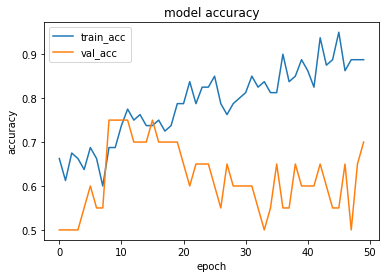

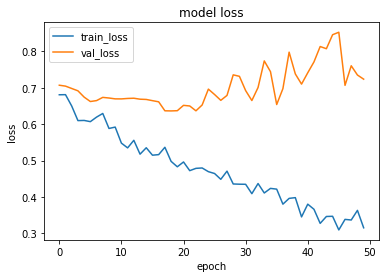

NameError: name 'cv2' is not defined

In [51]:
model_7.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
cross_validate(model_7, [])

In [ ]:
X.shape